# Smiles Dataset


In [ ]:
%pip install -U pandas numpy scikit-learn

## Introduction

In [1]:

CSV_PATH = "./datasets/spotify_churn_dataset.csv"  
TARGET_COL = "is_churned"                 
ID_COL = "user_id"


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)


In [4]:

# Read raw (let pandas infer, then coerce precisely)
df_raw = pd.read_csv(CSV_PATH)

# Make a copy to work with
df = df_raw.copy()

# --- Coerce types explicitly for this schema ---
# Categorical/text
cat_cols_expected = ["gender", "country", "subscription_type", "device_type"]
for c in cat_cols_expected:
    if c in df.columns:
        df[c] = (
            df[c]
            .astype("string")
            .str.strip()
        )

# Numeric
num_cols_expected = [
    "age",
    "listening_time",
    "songs_played_per_day",
    "skip_rate",
    "ads_listened_per_week",
]
for c in num_cols_expected:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ID (keep as nullable integer for safety; exclude from modeling later)
if ID_COL in df.columns:
    df[ID_COL] = pd.to_numeric(df[ID_COL], errors="coerce").astype("Int64")
    print(f"[info] Found ID column: {ID_COL}")

# offline_listening comes as 0/1 -> boolean
if "offline_listening" in df.columns:
    df["offline_listening"] = (
        pd.to_numeric(df["offline_listening"], errors="coerce")
          .map({1: True, 0: False})
          .astype("boolean")
    )

# Target (is_churned) as 0/1 -> int, keep NaN if weird values appear
if TARGET_COL in df.columns:
    y_tmp = pd.to_numeric(df[TARGET_COL], errors="coerce")
    bad = y_tmp.isna().sum()
    if bad > 0:
        print(f"[warn] {bad} rows in '{TARGET_COL}' could not be parsed as 0/1 (will be NaN).")
    df[TARGET_COL] = y_tmp.astype("Int64")
else:
    print(f"[warn] Target column '{TARGET_COL}' not found.")

print(f"[loaded] {df.shape[0]} rows × {df.shape[1]} columns")
display(df.head(5))


[info] Found ID column: user_id
[loaded] 8000 rows × 12 columns


,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,False,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,True,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,True,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,True,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,True,1


In [6]:
# --- Step 3: overview & missing-safe ---
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

print(f"Rows: {df.shape[0]} | Columns: {df.shape[1]}")
df.info()  # don't wrap with display(); it returns None

# Descriptive stats (numeric only)
print("\nNumeric summary:")
display(df.select_dtypes(include="number").describe().T)

# Categorical quick peek (top categories)
cat_cols = df.select_dtypes(include=["object", "string", "category"]).columns.tolist()
if cat_cols:
    print("\nCategorical top values (first 5 cols):")
    for c in cat_cols[:5]:
        print(f"\n[{c}]")
        display(df[c].value_counts(dropna=False).head(10))

# Missing values (safe if none)
missing = df.isna().mean().sort_values(ascending=False)
has_missing = (missing > 0).any()
if has_missing:
    print("\nMissing values found:")
    display(missing[missing > 0])

    plt.figure(figsize=(7,4))
    missing[missing > 0].sort_values().plot.barh()
    plt.title("Missing values per column")
    plt.xlabel("Fraction of missing")
    plt.tight_layout()
    plt.show()
else:
    print("\n[OK] No missing values detected. Skipping missing-values plot.")


Rows: 8000 | Columns: 12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                8000 non-null   Int64  
 1   gender                 8000 non-null   string 
 2   age                    8000 non-null   int64  
 3   country                8000 non-null   string 
 4   subscription_type      8000 non-null   string 
 5   listening_time         8000 non-null   int64  
 6   songs_played_per_day   8000 non-null   int64  
 7   skip_rate              8000 non-null   float64
 8   device_type            8000 non-null   string 
 9   ads_listened_per_week  8000 non-null   int64  
 10  offline_listening      8000 non-null   boolean
 11  is_churned             8000 non-null   Int64  
dtypes: Int64(2), boolean(1), float64(1), int64(4), string(4)
memory usage: 718.9 KB

Numeric summary:


,count,mean,std,min,25%,50%,75%,max
user_id,8000.0,4000.5,2309.54541,1.0,2000.75,4000.5,6000.25,8000.0
age,8000.0,37.662125,12.740359,16.0,26.0,38.0,49.0,59.0
listening_time,8000.0,154.06825,84.015596,10.0,81.0,154.0,227.0,299.0
songs_played_per_day,8000.0,50.12725,28.449762,1.0,25.0,50.0,75.0,99.0
skip_rate,8000.0,0.300127,0.173594,0.0,0.15,0.3,0.45,0.6
ads_listened_per_week,8000.0,6.943875,13.617953,0.0,0.0,0.0,5.0,49.0
is_churned,8000.0,0.258875,0.438044,0.0,0.0,0.0,1.0,1.0



Categorical top values (first 5 cols):

[gender]


gender
Male      2691
Female    2659
Other     2650
Name: count, dtype: Int64


[country]


country
AU    1034
US    1032
DE    1015
IN    1011
PK     999
FR     989
UK     966
CA     954
Name: count, dtype: Int64


[subscription_type]


subscription_type
Premium    2115
Free       2018
Student    1959
Family     1908
Name: count, dtype: Int64


[device_type]


device_type
Desktop    2778
Web        2623
Mobile     2599
Name: count, dtype: Int64


[OK] No missing values detected. Skipping missing-values plot.


[INFO] Churn rate: 25.89%


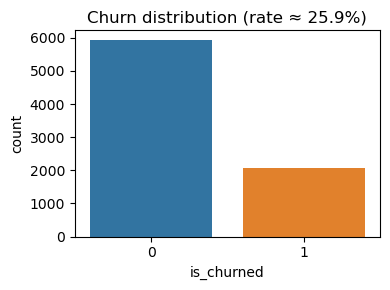

Numeric columns: ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week']


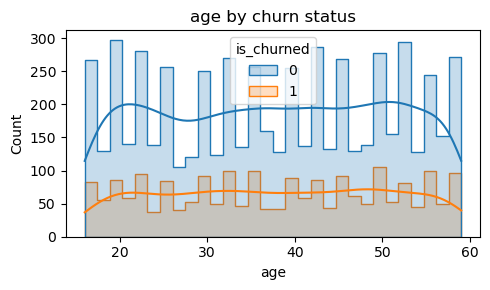

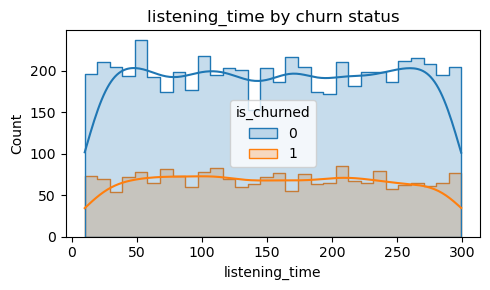

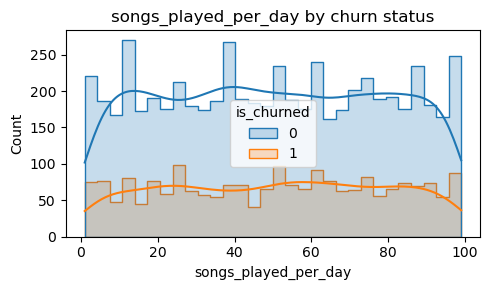

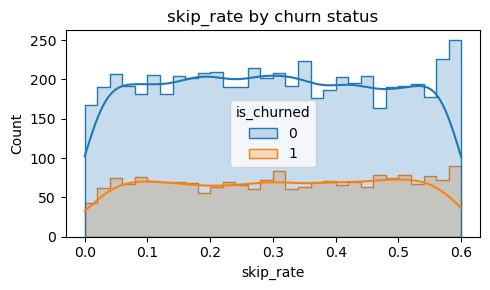

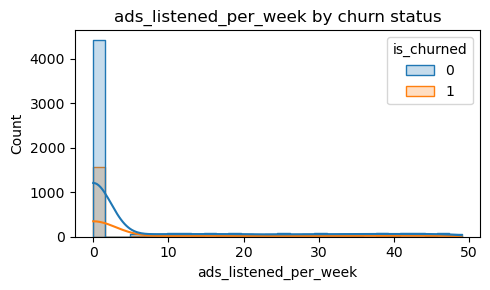

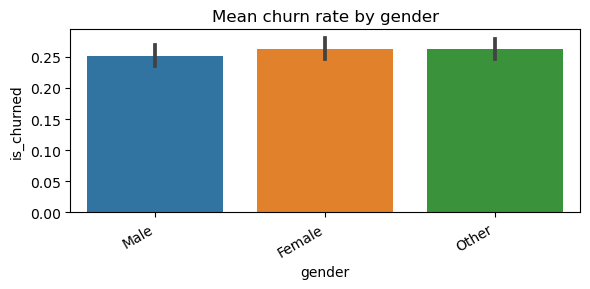

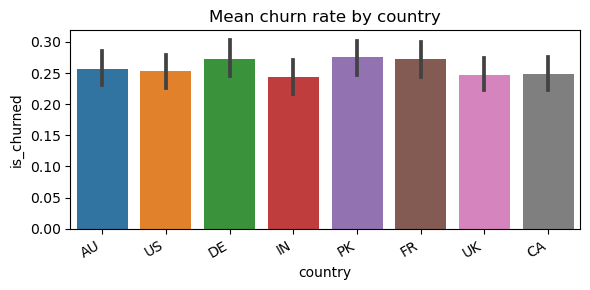

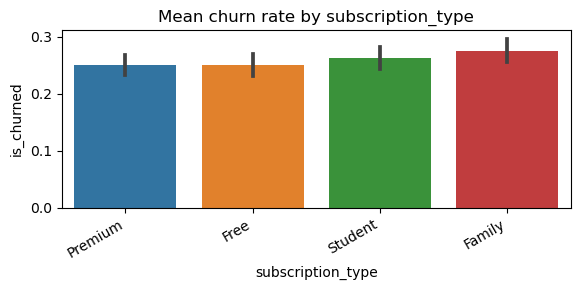

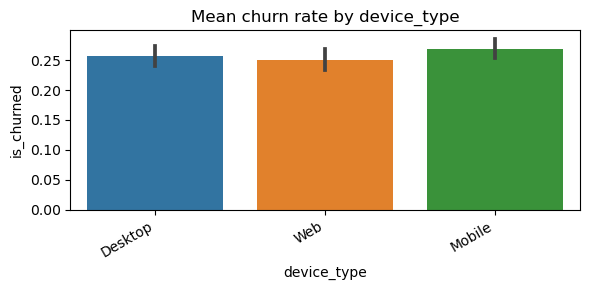

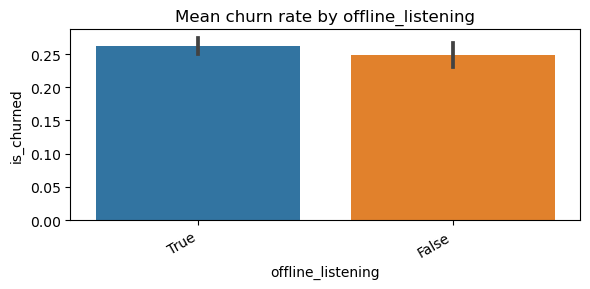

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


# --- 4.1  Check churn balance ---
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found.")

churn_rate = df[TARGET_COL].mean()
print(f"[INFO] Churn rate: {churn_rate:.2%}")

plt.figure(figsize=(4,3))
sns.countplot(x=TARGET_COL, data=df)
plt.title(f"Churn distribution (rate ≈ {churn_rate:.1%})")
plt.tight_layout()
plt.show()


# --- 4.2  Numeric features vs churn ---
num_cols = df.select_dtypes(include=["number"]).columns.drop([TARGET_COL, "user_id"], errors="ignore")

print(f"Numeric columns: {list(num_cols)}")

for col in num_cols:
    plt.figure(figsize=(5,3))
    sns.histplot(data=df, x=col, hue=TARGET_COL, kde=True, bins=30, element="step")
    plt.title(f"{col} by churn status")
    plt.tight_layout()
    plt.show()


# --- 4.3  Categorical features vs churn (bar charts) ---
cat_cols = df.select_dtypes(include=["object", "string", "category"]).columns.tolist() + \
           df.select_dtypes(include=["bool"]).columns.tolist()

for col in cat_cols:
    if df[col].nunique(dropna=True) <= 15:  # avoid overcrowding
        plt.figure(figsize=(6,3))
        sns.barplot(
            data=df,
            x=col, y=TARGET_COL,
            estimator=np.mean,
            order=df[col].value_counts().index
        )
        plt.title(f"Mean churn rate by {col}")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.show()


## Preprocessing


In [8]:
from sklearn.model_selection import train_test_split

TARGET_COL = "is_churned"
ID_COL = "user_id"

# --- 5.1 Separate target and drop ID ---
X = df.drop(columns=[TARGET_COL, ID_COL], errors="ignore")
y = df[TARGET_COL]

# --- 5.2 Split train/test (keep churn proportion consistent) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print(f"Churn rate train = {y_train.mean():.2%} | test = {y_test.mean():.2%}")

# --- 5.3 Identify column types (for preprocessing) ---
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "string", "category"]).columns.tolist()
bool_cols = X_train.select_dtypes(include=["bool"]).columns.tolist()

print("\nNumeric cols:", num_cols)
print("Categorical cols:", cat_cols)
print("Boolean cols:", bool_cols)

# --- optional: ensure bool → int for modeling simplicity ---
for c in bool_cols:
    X_train[c] = X_train[c].astype(int)
    X_test[c] = X_test[c].astype(int)


Train: (6400, 10) | Test: (1600, 10)
Churn rate train = 25.89% | test = 25.87%

Numeric cols: ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week']
Categorical cols: ['gender', 'country', 'subscription_type', 'device_type']
Boolean cols: ['offline_listening']


## Train


In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import numpy as np

# --- define preprocessing ---
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

# --- define models ---
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42, max_depth=None),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "ANN": MLPClassifier(hidden_layer_sizes=(64, 32), activation="relu", max_iter=300, random_state=42)
}

# --- train & evaluate each ---
results = []
for name, model in models.items():
    print(f"\n🧠 Training {name} ...")
    pipe = Pipeline(steps=[("preprocess", preprocessor),
                           ("model", model)])
    pipe.fit(X_train, y_train)

    # predictions (use the PIPELINE, not the bare model)
    y_pred = pipe.predict(X_test)

    # probabilities / scores (again from the PIPELINE)
    try:
        y_prob = pipe.predict_proba(X_test)[:, 1]
    except AttributeError:
        # e.g., SVM without probas (or any model lacking predict_proba)
        if hasattr(pipe, "decision_function"):
            scores = pipe.decision_function(X_test)
            # min-max normalize to [0,1] for ROC-AUC
            y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        else:
            # fallback: cast preds to float
            y_prob = y_pred.astype(float)

    acc = accuracy_score(y_test, y_pred)
    try:
        auc = roc_auc_score(y_test, y_prob)
    except ValueError:
        # If only one class in y_test (rare), fall back to accuracy as proxy
        auc = np.nan

    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc if not np.isnan(auc) else 'NA'}")
    print(classification_report(y_test, y_pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    results.append({"Model": name, "Accuracy": acc, "ROC-AUC": auc})

results_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False, na_position="last")
display(results_df)




🧠 Training DecisionTree ...
Accuracy: 0.606 | ROC-AUC: 0.5107147803276552
              precision    recall  f1-score   support

         0.0      0.747     0.707     0.727      1186
         1.0      0.273     0.314     0.292       414

    accuracy                          0.606      1600
   macro avg      0.510     0.511     0.509      1600
weighted avg      0.624     0.606     0.614      1600

Confusion matrix:
 [[839 347]
 [284 130]]

🧠 Training RandomForest ...
Accuracy: 0.738 | ROC-AUC: 0.5427257211753875
              precision    recall  f1-score   support

         0.0      0.742     0.990     0.848      1186
         1.0      0.333     0.014     0.028       414

    accuracy                          0.738      1600
   macro avg      0.538     0.502     0.438      1600
weighted avg      0.636     0.738     0.636      1600

Confusion matrix:
 [[1174   12]
 [ 408    6]]

🧠 Training SVM ...
Accuracy: 0.741 | ROC-AUC: 0.4664625950094093
              precision    recall  f1-scor

c:\Users\utilizador\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\utilizador\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\utilizador\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.643 | ROC-AUC: 0.5429324404689168
              precision    recall  f1-score   support

         0.0      0.746     0.787     0.766      1186
         1.0      0.275     0.232     0.252       414

    accuracy                          0.643      1600
   macro avg      0.510     0.509     0.509      1600
weighted avg      0.624     0.643     0.633      1600

Confusion matrix:
 [[933 253]
 [318  96]]


c:\Users\utilizador\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,Accuracy,ROC-AUC
3,ANN,0.643125,0.542932
1,RandomForest,0.737500,0.542726
0,DecisionTree,0.605625,0.510715
2,SVM,0.741250,0.466463
